# SNIS IPLA

In [1]:
import numpy as np
from tqdm import tqdm
from implementation import IPLA, SNIS_IPLA, PGD, SVGD_EM
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [2]:
# increase default precision of numpy

## Auxiliary functions

We will test with:

$$
p(\theta,x, y) = \prod_{d=1}^D\exp\left(-\frac{(x_d-\theta)^2}{2} - \frac{(y_d-x_d)^2}{2}-\log(2\pi)\right)
$$

$$
= \exp\left(-D\log(2\pi)-\left[\sum_{d=1}^D\frac{(x_d-\theta)^2}{2} + \frac{(y_d-x_d)^2}{2}\right]\right)
$$

$$
\nabla_\theta p(\theta,x,y) = p(\theta, x, y)\left\{\sum_{d=1}^D x_d - D\theta\right\}
$$

In [3]:
def p(theta, x, y):
    D = np.shape(x)[0]
    return np.exp(-np.sum((x-theta)**2/2) - np.sum((y-x)**2/2) - D*np.log(2*np.pi))

def p_grad_theta(theta, x, y):
    D = np.shape(x)[0]
    return -(np.sum(x) - D*theta) * p(theta, x, y)

def log_p_grad_theta(theta, x, y):
    D = x.shape[0]
    return (np.sum(x) - D*theta)*p(theta, x, y)

def U(theta, Xi, y):
    D = np.shape(Xi)[0]
    return D * np.log(2*np.pi) + np.sum((Xi-theta)**2/2) + np.sum((y-Xi)**2/2)

def U_grad_X(theta, x, y):
    return -(-2*x + y + theta)

def U_grad_theta(theta, Xi, y):
    D = np.shape(Xi)[0]
    return D*(theta - np.mean(Xi))

def ave_grad_U_theta(theta, X, y):
    D, N = np.shape(X)
    return D*(theta - np.mean(X))

def exponential_kernel(x1, x2, sigma=1):
    return np.exp(-np.sum((x1-x2)**2)/(2*sigma**2))

def grad_exponential_kernel_x1(x1, x2, sigma=1):
    return ((x2-x1)/(sigma**2)) * np.exp(-np.sum((x1-x2)**2/(2*sigma**2)))

# SNIS IPLA

In [4]:
D = 50
nsteps = 500
Nparticles = 10
thdata = 4
X0 = np.zeros((D, Nparticles))
th0  = np.array([0.0])
y = np.random.normal(0,1, (D,1)) + np.random.normal(thdata, 1, (D,1))
best_theta = y.mean()*np.ones(nsteps)
grads_U_IPLA = (ave_grad_U_theta, U_grad_X)
grads_U_SNIS = (U_grad_theta, U_grad_X)

In [5]:
gamma_experiments = 1e-2
nexperiments = 1
average_thetas_dict = {"PGD": np.zeros((nsteps+1,1)), "IPLA": np.zeros((nsteps+1,1)),"SNIS-IPLA": np.zeros((nsteps+1,1)), "SVGD-EM": np.zeros((nsteps+1,1))}
for experiment in tqdm(range(nexperiments)):
    y = np.random.normal(0,1, (D,1)) + np.random.normal(thdata, 1, (D,1))
    PGD_test = PGD(th0, X0, grads_U_IPLA, gamma=gamma_experiments, y=y)
    IPLA_test = IPLA(th0, X0, grads_U_IPLA, gamma=gamma_experiments, y=y)
    SNIS_IPLA_test = SNIS_IPLA(th0, X0, U, grads_U_SNIS, gamma=gamma_experiments, test=False, y=y)
    SVGD_EM_test = SVGD_EM(th0, X0, grads_U_IPLA, exponential_kernel, grad_exponential_kernel_x1, gamma=gamma_experiments, noise=False, y=y)
    for i in tqdm(range(nsteps)):
        PGD_test.iterate()
        IPLA_test.iterate()
        SNIS_IPLA_test.iterate()
        SVGD_EM_test.iterate()

    average_thetas_dict["PGD"] = average_thetas_dict["PGD"] + 1/nexperiments * np.array(PGD_test.thetas)
    average_thetas_dict["IPLA"] = average_thetas_dict["IPLA"] + 1/nexperiments * np.array(IPLA_test.thetas)
    average_thetas_dict["SNIS-IPLA"] = average_thetas_dict["SNIS-IPLA"] + 1/nexperiments * np.array(SNIS_IPLA_test.thetas)
    average_thetas_dict["SVGD-EM"] = average_thetas_dict["SVGD-EM"] + 1/nexperiments * np.array(SVGD_EM_test.thetas)




100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


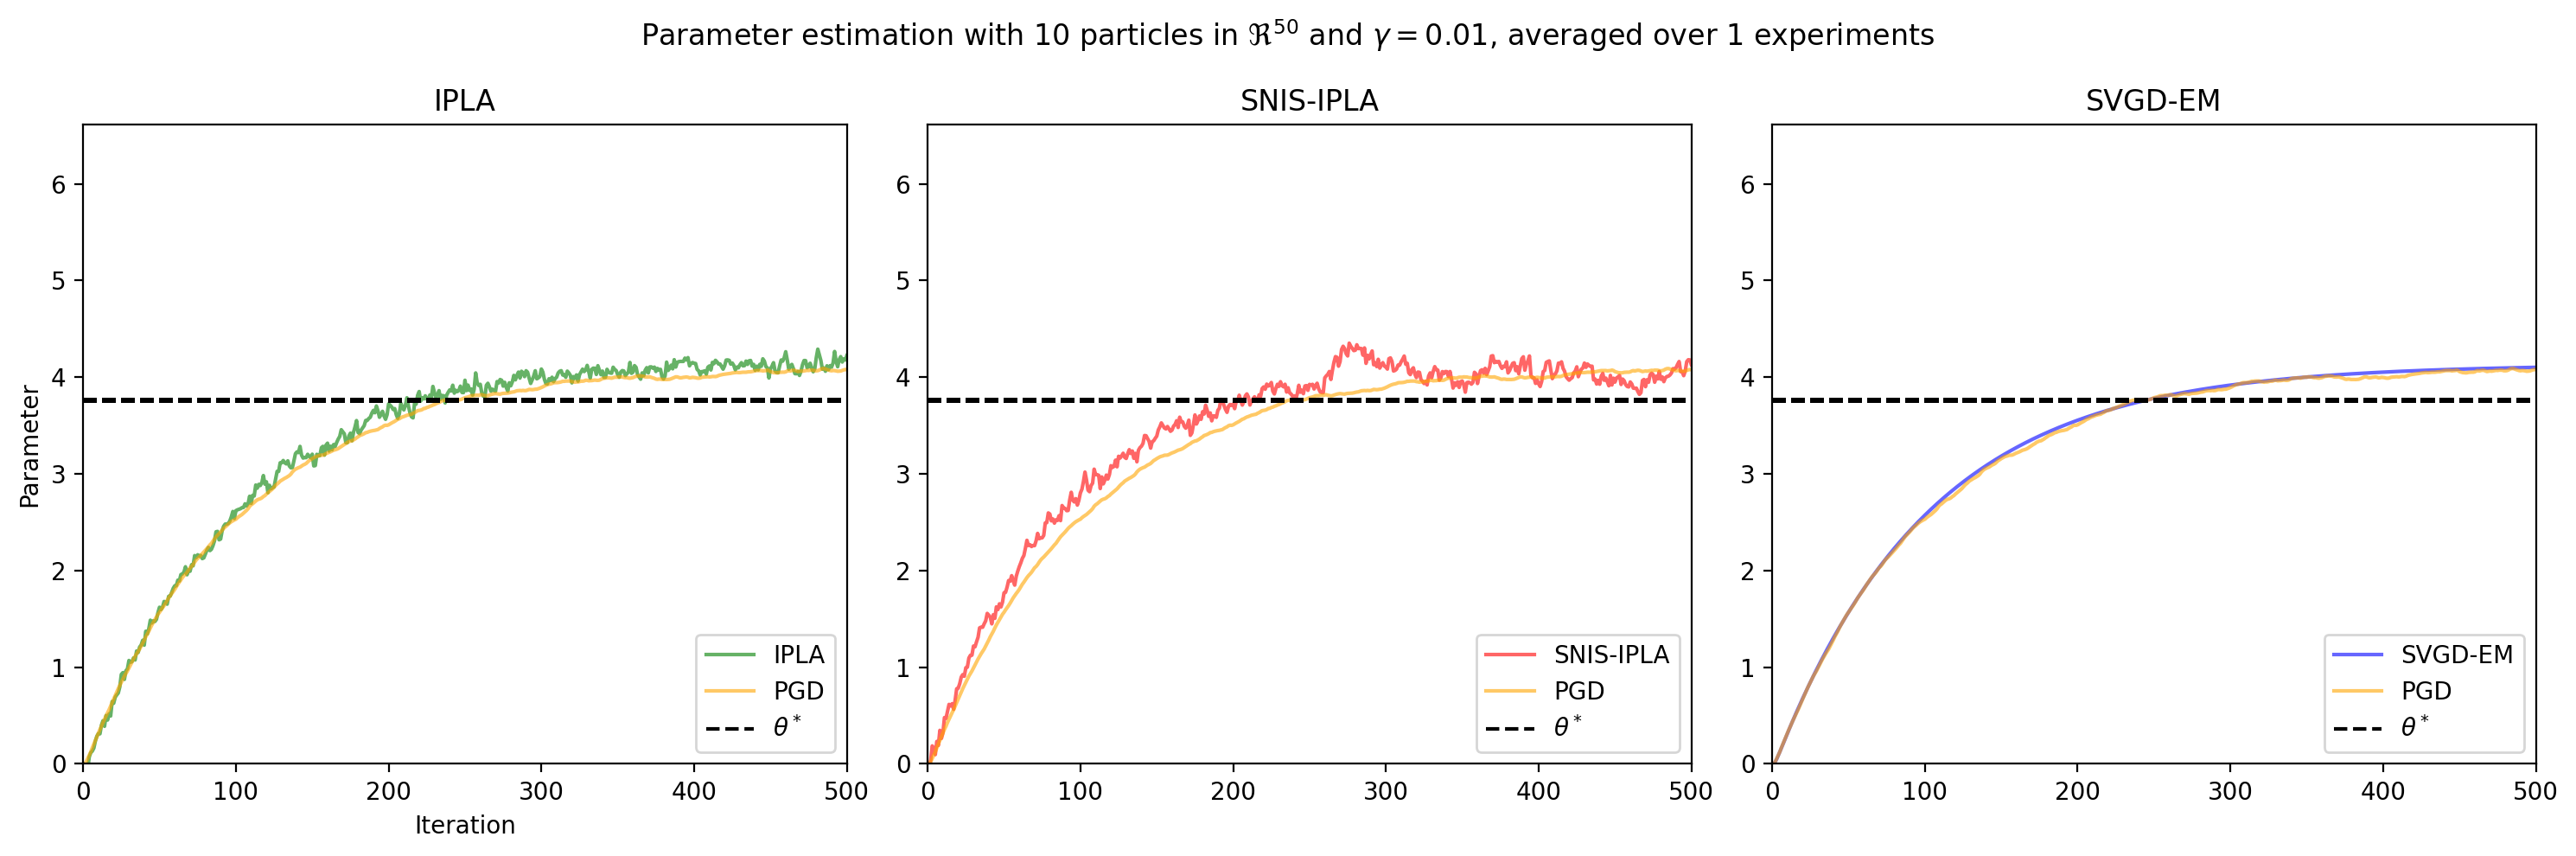

In [6]:
# Plot the results
# make two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))


ax1.plot(average_thetas_dict["IPLA"], color = "green", label="IPLA", alpha=0.6)
ax2.plot(average_thetas_dict["SNIS-IPLA"], color = "red", label="SNIS-IPLA", alpha=0.6)
ax3.plot(average_thetas_dict["SVGD-EM"], color = "blue", label="SVGD-EM", alpha=0.6)
ax1.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax2.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax3.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax1.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax2.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax3.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Parameter')
ax1.set_xlim([0, nsteps])
ax1.set_ylim([0, 1.6*y.mean()])
ax1.set_title(f'IPLA')
ax1.legend(loc="lower right")
ax2.set_title(f'SNIS-IPLA')
ax2.legend(loc="lower right")
ax2.set_xlim([0, nsteps])
ax2.set_ylim([0, 1.6*y.mean()])
ax3.set_title(f'SVGD-EM')
ax3.legend(loc="lower right")
ax3.set_xlim([0, nsteps])
ax3.set_ylim([0, 1.6*y.mean()])

#ax1.set_yscale("log")
#ax2.set_yscale("log")
fig.suptitle(f"Parameter estimation with {Nparticles} particles in $\Re^{{{D}}}$ and $\gamma = {gamma_experiments}$, averaged over {nexperiments} experiments")
fig.tight_layout()
plt.show()

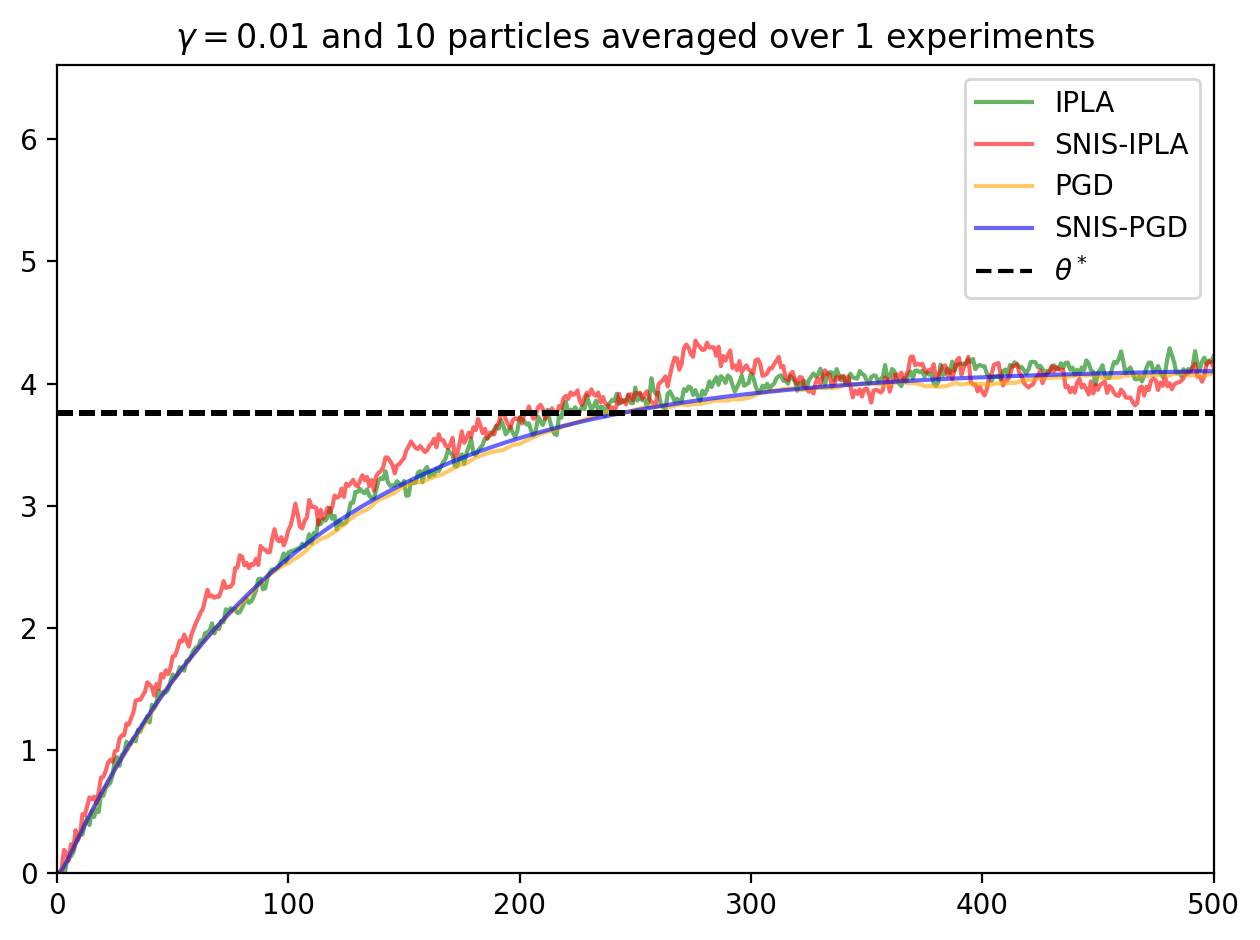

In [7]:
plt.plot(average_thetas_dict["IPLA"], color = "green", label="IPLA", alpha=0.6)
plt.plot(average_thetas_dict["SNIS-IPLA"], color = "red", label="SNIS-IPLA", alpha=0.6)
plt.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
plt.plot(average_thetas_dict["SVGD-EM"], color = "blue", label="SNIS-PGD", alpha=0.6)
plt.hlines(best_theta, 0, nsteps+1, linestyles="dashed", label = "$\\theta^*$", color="black")
plt.title(f"$\gamma = {gamma_experiments}$ and {Nparticles} particles averaged over {nexperiments} experiments")
plt.xlim([0, nsteps])
plt.ylim([0, 1.6*y.mean()])
plt.legend()
plt.tight_layout()
plt.show()

Our iterates are of the form:

\begin{align*}
\theta_{k+1} &= \theta_n - \gamma \sum_{i=1}^N W_i^k \nabla_{\theta}U(\theta_k, X_i^k) + \sqrt{\frac{2\gamma}{N}}N_k\\
X_i^{k+1} &= X_i^k - \gamma \nabla_{X}U(\theta_k, X_i^k) + \sqrt{2\gamma}N_i^k
\end{align*}
Where:

$$
W_i^k = \frac{\exp(- U(\theta_k,X_i^k))}{\sum_{j=1}^{N} \exp(-U(\theta_k,X_j^k))}
$$

We can then rewrite the $\theta$ update as:
\begin{align*}
\theta_{k+1} &= \theta_n + \frac{\gamma}{\sum_{j=1}^{N} \exp(-U(\theta_k,X_j^k))} \sum_{i=1}^N \nabla_\theta\exp(- U(\theta_k,X_i^k)) + \sqrt{\frac{2\gamma}{N}}N_k\\
X_i^{k+1} &= X_i^k - \gamma \nabla_{X}U(\theta_k, X_i^k) + \sqrt{2\gamma}N_i^k
\end{align*}

Recall that $U(\theta, X)=-\log p(\theta, X)$, so $p(\theta,\,X_i^k) = \exp(- U(\theta_k,X_i^k))$ and $\nabla_\theta\exp(- U(\theta_k,X_i^k)) = \nabla_\theta p(\theta,\,X_i^k)$. Hence:
\begin{align*}
\theta_{k+1} &= \theta_n + \frac{\gamma}{\sum_{j=1}^{N} p(\theta,\,X_j^k)} \sum_{i=1}^N \nabla_\theta p(\theta,\,X_i^k) + \sqrt{\frac{2\gamma}{N}}N_k\\
X_i^{k+1} &= X_i^k - \gamma \nabla_{X}U(\theta_k, X_i^k) + \sqrt{2\gamma}N_i^k
\end{align*}

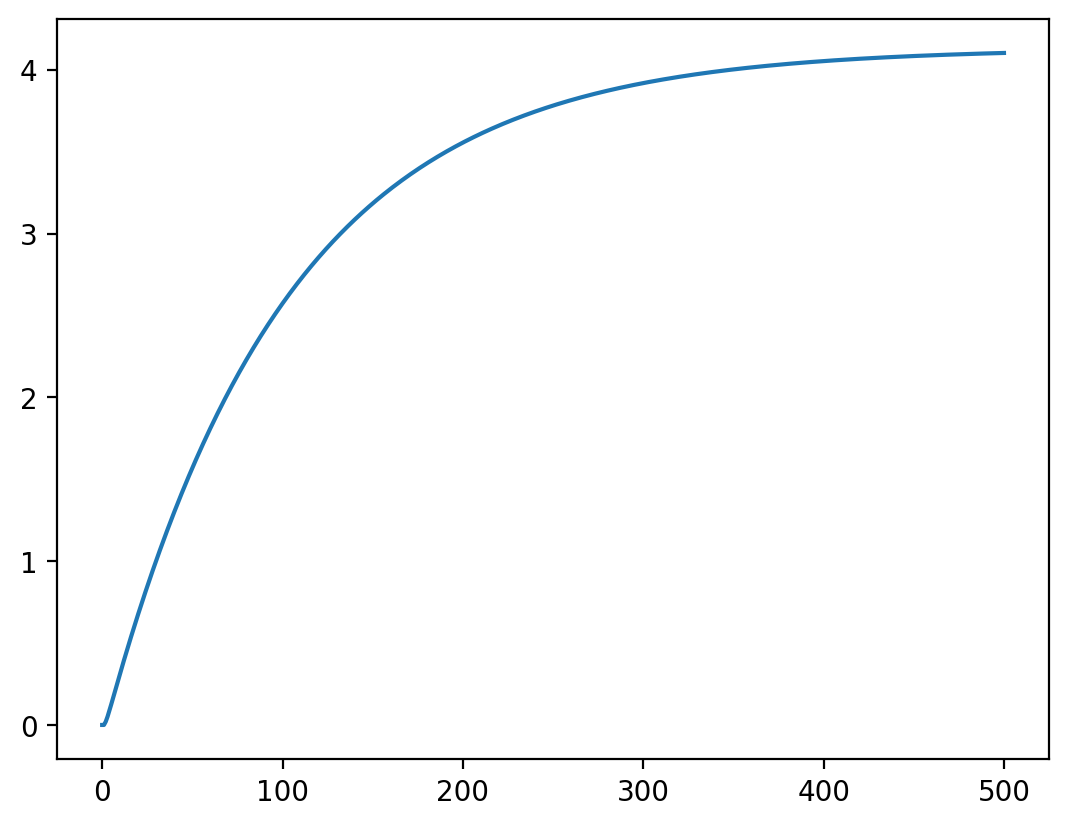

In [8]:
# plot thetas for stochastic SVGD EM
plt.plot(SVGD_EM_test.thetas)
# plot dots in the thetas whose indices are present in SVGD_EM_test.j_iter
plt.scatter(SVGD_EM_test.j_iter, [SVGD_EM_test.thetas[j] for j in SVGD_EM_test.j_iter], color='red')